In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

In [9]:
from sklearn.metrics import log_loss

In [2]:
import autokeras as ak

In [ ]:
import keras
from keras.models import Model
import kerastuner

## Keras notebook, improvement over moa-basic-keras
1. Manually transform data: categorical, simple MinMaxScaler, categorical, PowerTransformer.
1. Run another basic autokeras on this more amenable dataset.
1. Tune the resulting keras-from-autokeras model.
1. Architect a similar model to one of the top performing notebooks on Kaggle.
1. Tune this model architecture.
1. Compare results and consider possibilities for improvements:
    1. Transformers
    1. RNNs
    1. Do more research
1. Additional possibilities from Kaggle notebooks and elsewhere:
    1. More sophisticated dimensionality reduction with t-SNE
    

In [4]:
tf_df = pd.read_csv('../train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')
transformer = PowerTransformer()
tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])

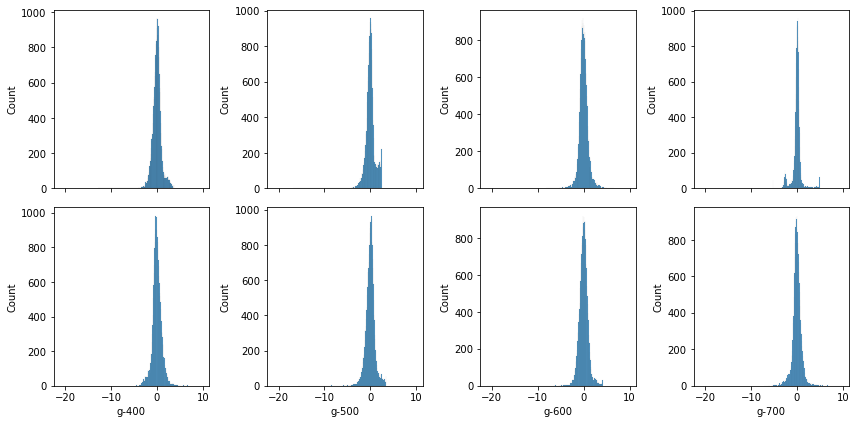

In [6]:
f, axs = plt.subplots(2,4,figsize=(12,6),sharex=True)
for i in range(0,701,100):
    sns.histplot(data=tf_df,x='g-'+str(i),ax=axs[i//400,i%400//100])
f.tight_layout()

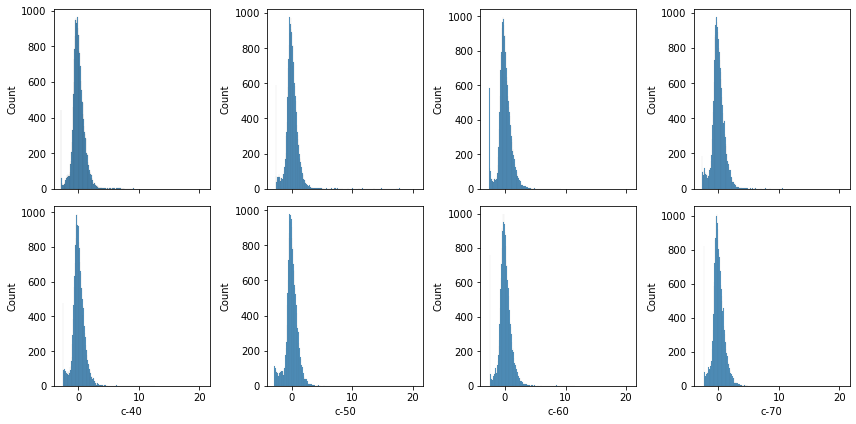

In [7]:
f, axs = plt.subplots(2,4,figsize=(12,6),sharex=True)
for i in range(0,71,10):
    sns.histplot(data=tf_df,x='c-'+str(i),ax=axs[i//40,i%40//10])
f.tight_layout()

Not as elegant as I hoped, but to my knowledge this should train significantly better.

In [8]:
ak_pass2 = ak.StructuredDataClassifier(overwrite=True,max_trials=5,loss='binary_crossentropy',
                                       metrics=['binary_crossentropy','accuracy'])
ak_pass2.fit(tf_df,tts_df,epochs=10)

Trial 5 Complete [00h 06m 27s]
val_accuracy: 0.08962462842464447

Best val_accuracy So Far: 0.10080134868621826
Total elapsed time: 00h 28m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
745/745 [==============================] - 25s 34ms/step - loss: 3.5734 - binary_crossentropy: 0.0220 - accuracy: 0.0403
Epoch 2/10
745/745 [==============================] - 27s 36ms/step - loss: 3.9371 - binary_crossentropy: 0.0221 - accuracy: 0.0580
Epoch 3/10
745/745 [==============================] - 27s 36ms/step - loss: 5.0767 - binary_crossentropy: 0.0241 - accuracy: 0.0446
Epoch 4/10
745/745 [==============================] - 26s 34ms/step - loss: 6.5732 - binary_crossentropy: 0.0254 - accuracy: 0.0372
Epoch 5/10
745/745 [==============================] - 45s 60ms/step - loss: 6.9710 - binary_crossentropy: 0.0260 - accuracy: 0.0357
Epoch 6/10
745/745 [==============================] - 43s 57ms/step - loss: 8.1273 - binary_crossentropy: 0.0259 - accuracy: 0.0352
Epoch 7/10
745/745 [======

In [10]:
preds = ak_pass2.predict(tf_df)
log_loss(tts_df,preds)

21.665417056654878

In [11]:
ak_pass2.evaluate(tf_df,tts_df)

745/745 [==============================] - 17s 23ms/step - loss: 5.0789 - binary_crossentropy: 0.0203 - accuracy: 0.0417


[5.078915119171143, 0.020280111581087112, 0.04174015298485756]

In [12]:
preds = ak_pass2.predict(tf_df)
log_loss(tts_df,preds)

21.665417056654878

In [13]:
keras2 = ak_pass2.export_model()

In [14]:
keras2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 875)               0         
_________________________________________________________________
normalization (Normalization (None, 875)               1751      
_________________________________________________________________
dense (Dense)                (None, 64)                56064     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Compare this to the previous autokeras model. This one's log loss is even a little worse than that one; neither is at all credible.